In [1]:
from src import preprocessing, dataLoader, machineLearning
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# import matplotlib.pyplot as plt

In [2]:
filePath="./data/financial.db"
# dataframe = preprocessing.loadAllData(filePath)

In [3]:
dfAcct, medianPerDistrict, meanPerDistrict, medianChange, meanChange, dfAcctsPctChange = dataLoader.loadAccountMedianMeanDataframes(filePath)
allXColumns = ['district_id','numInhabitants', 'municipalitiesLess500','municipalities500to2k','municipalities2kto10k','municipalitiesGreater10k','numCities',                   
           'ratioUrbanInhabitants','avgSalary','unEmployment95','unEmployment96', 'entrepeneursPer1k', 'crimesIn95', 'crimesIn96' ] 
yVector = ['balance']

### Random Forest Regression

Feature ranking:
1. feature 10 (0.151131)
2. feature 2 (0.102222)
3. feature 1 (0.088026)
4. feature 11 (0.086790)
5. feature 0 (0.080105)
6. feature 8 (0.078091)
7. feature 3 (0.066967)
8. feature 4 (0.064488)
9. feature 9 (0.058220)
10. feature 7 (0.058056)
11. feature 5 (0.048041)
12. feature 12 (0.045794)
13. feature 13 (0.043164)
14. feature 6 (0.028905)


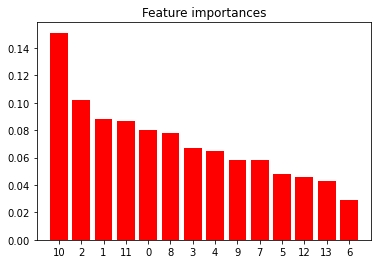

0.04322513500970655

In [4]:
randomForestAccuracy_MedianChangePerDistrict = machineLearning.applyModelToDataframe(medianChange, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy_MedianChangePerDistrict['MeanSquareError']

Feature ranking:
1. feature 10 (0.115948)
2. feature 1 (0.100265)
3. feature 11 (0.096142)
4. feature 9 (0.087835)
5. feature 0 (0.084835)
6. feature 2 (0.078952)
7. feature 4 (0.076621)
8. feature 3 (0.061851)
9. feature 8 (0.057836)
10. feature 12 (0.054356)
11. feature 13 (0.053459)
12. feature 5 (0.051472)
13. feature 7 (0.049477)
14. feature 6 (0.030952)


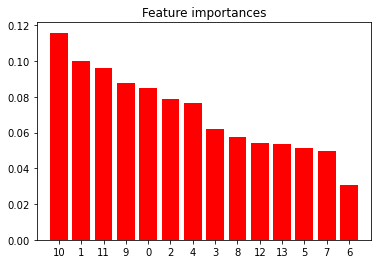

0.027255016871922725

In [5]:
randomForestAccuracy_MeanChangePerDistrict = machineLearning.applyModelToDataframe(meanChange, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy_MeanChangePerDistrict['MeanSquareError']

Feature importances seem to vary between runs. This is likely due to the nature of how random forests work (i.e. by randomly selecting features at each branch), especially given that the dataset is relatively small as well. 

### Linear Regression

The random forest regressor might actually be overkill. Below is the implementation of linear regression. 

In [6]:
linearRegresssionAccuracy_MedianChangePerDistrict = machineLearning.applyModelToDataframe(medianChange, allXColumns, yVector, LinearRegression, True)
linearRegresssionAccuracy_MedianChangePerDistrict['MeanSquareError']

1.50604470927688

In [7]:
linearRegresssionAccuracy_MedianChangePerDistrict = machineLearning.applyModelToDataframe(meanChange, allXColumns, yVector, LinearRegression, True)
linearRegresssionAccuracy_MedianChangePerDistrict['MeanSquareError']

0.05937387806535182

In [8]:
#
linearRegresssionAccuracy_MedianChangePerDistrict_3Highest =  machineLearning.applyModelToDataframe(medianChange, ['avgSalary','unEmployment95','unEmployment96' ], yVector, LinearRegression, True)
linearRegresssionAccuracy_MedianChangePerDistrict_3Highest['MeanSquareError']

0.03621134779044692

In [9]:
linearRegresssionAccuracy_MedianChangePerDistrict_3Highest =  machineLearning.applyModelToDataframe(meanChange, ['avgSalary','unEmployment95','unEmployment96' ], yVector, LinearRegression, True)
linearRegresssionAccuracy_MedianChangePerDistrict_3Highest['MeanSquareError']

0.03162120778796371

### Attempts at District Classification by Acct Percent Change

Below are attempts at classification of the district from the percent changed on the account. As can be seen from the below returned values, the accuracy was relatively abysmal: 

In [10]:
balanceRatioSalary =  ['balance']  
yVector = ['district_id']

In [11]:
randomForestClassificationDfAcct = machineLearning.applyModelToDataframe(dfAcct, balanceRatioSalary, yVector, RandomForestClassifier, False )
randomForestClassificationMedian = machineLearning.applyModelToDataframe(medianPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationMean = machineLearning. applyModelToDataframe(meanPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationDfAcct_Change = machineLearning. applyModelToDataframe(dfAcctsPctChange.dropna(), balanceRatioSalary, yVector, RandomForestClassifier, False )
randomForestClassificationMedian_Change = machineLearning. applyModelToDataframe(medianChange, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationMean_Change = machineLearning. applyModelToDataframe(meanChange, balanceRatioSalary, yVector, RandomForestClassifier, False  )



In [12]:
print(f"""
randomForestClassificationDfAcct {randomForestClassificationDfAcct}
randomForestClassificationMedian {randomForestClassificationMedian}
randomForestClassificationMean {randomForestClassificationMean}
randomForestClassificationDfAcct_Change {randomForestClassificationDfAcct_Change}
randomForestClassificationMedian_Change {randomForestClassificationMedian_Change}
randomForestClassificationMean_Change {randomForestClassificationMean_Change}
""")


randomForestClassificationDfAcct {'kFoldAccuracyScore': 0.031061292127122848, 'classificationAcc': 0.03133903133903134, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMedian {'kFoldAccuracyScore': 0.02604020570359981, 'classificationAcc': 0.02127659574468085, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMean {'kFoldAccuracyScore': 0.008625525946704068, 'classificationAcc': 0.0, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationDfAcct_Change {'kFoldAccuracyScore': 0.02364937374332193, 'classificationAcc': 0.030555555555555555, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMedian_Change {'kFoldAccuracyScore': 0.0, 'classificationAcc': 0.0, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMean_Change {'kFoldAccuracyScore': 0.0, 'classificationAcc': 0.0, 'meanOfDifferencesInPrediction': 0.0}



## Loan Data Classification

While the Mean Squared Error values of the regressors appear low, the high variance did leave little confidence in the data. Below are attempts at loan data classification: 

In [13]:
someData = preprocessing.loadLoanDataWithDistrictDF(filePath, True)

In [14]:
loanDF = someData[someData['status'].notna()].drop(['card_id', 'type_y', 'issued', 'date_y', 'date_x', 'issued', 'type_y', 'issued'], axis=1)
loanDF[loanDF['district_id' ]==15]

,account_id,district_id,frequency,disp_id,client_id,type_x,gender,birth_date,district_id_y,loan_id,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
856,314,15,2,383,383,0,0,-9.665424e+08,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
857,314,15,2,384,384,1,1,-1.080328e+09,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
906,4825,15,0,5826,5826,0,1,-4.137120e+07,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
907,4825,15,0,5827,5827,1,0,1.601172e+08,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
908,5283,15,0,6383,6383,0,1,5.364000e+05,15,6078.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
910,5572,15,0,6729,6729,0,1,-3.791052e+08,15,6136.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
911,5593,15,0,6753,6753,0,1,-2.401776e+08,15,6144.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
912,5927,15,0,7166,7166,0,1,-1.778832e+08,15,6210.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
915,11265,15,0,13537,13845,0,1,9.868680e+07,15,7284.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879


### Random Forest Classification: 

Feature ranking:
1. feature 11 (0.173298)
2. feature 10 (0.102693)
3. feature 12 (0.080943)
4. feature 9 (0.058665)
5. feature 0 (0.053963)
6. feature 3 (0.053823)
7. feature 7 (0.051945)
8. feature 4 (0.051159)
9. feature 8 (0.034139)
10. feature 21 (0.030446)
11. feature 24 (0.024974)
12. feature 14 (0.024848)
13. feature 23 (0.023553)
14. feature 25 (0.022938)
15. feature 1 (0.022787)
16. feature 15 (0.021815)
17. feature 26 (0.021242)
18. feature 22 (0.021075)
19. feature 16 (0.020398)
20. feature 17 (0.020102)
21. feature 20 (0.018665)
22. feature 19 (0.017558)
23. feature 13 (0.013261)
24. feature 2 (0.012328)
25. feature 18 (0.009890)
26. feature 6 (0.009488)
27. feature 5 (0.004007)


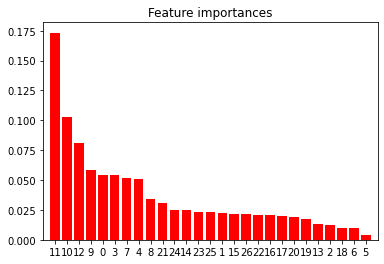

0.7951807228915663

In [15]:
loanDataRandomForestClassificationAcc=machineLearning.applyModelToDataframe(loanDF, ['account_id', 'district_id', 'frequency', 'disp_id', 'client_id', 'type_x', 
                                        'gender', 'birth_date', 'district_id_y', 'loan_id', 'amount',
                                       'duration', 'payments', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
                                       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'], ['status'], RandomForestClassifier, False, 'randomForest')
loanDataRandomForestClassificationAcc['classificationAcc']

Feature ranking:
1. feature 0 (0.419529)
2. feature 2 (0.387492)
3. feature 1 (0.192979)


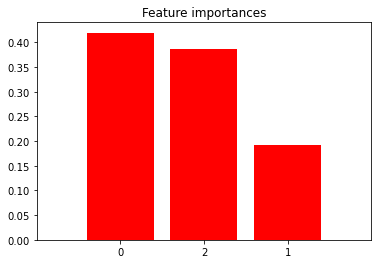

0.6626506024096386

In [16]:
accuracy= machineLearning.applyModelToDataframe(loanDF, ['amount', 'duration', 'payments'], ['status'], RandomForestClassifier, False, 'randomForest')
accuracy['classificationAcc']

Feature ranking:
1. feature 5 (0.219093)
2. feature 6 (0.210299)
3. feature 7 (0.193789)
4. feature 3 (0.165308)
5. feature 4 (0.143549)
6. feature 0 (0.029075)
7. feature 2 (0.024740)
8. feature 1 (0.014147)


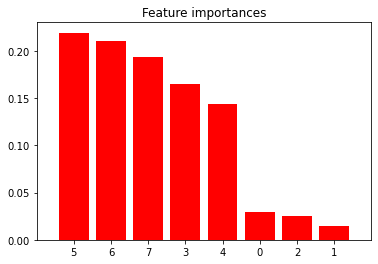

0.7469879518072289

In [17]:
xCols =  [ 'frequency', 'type_x', 'gender', 'birth_date', 'district_id_y',
            'amount', 'duration', 'payments']
yCol = [ 'status' ]

acc = machineLearning.applyModelToDataframe(loanDF, xCols, yCol, RandomForestClassifier, False, 'randomForest')
acc['classificationAcc']

Feature ranking:
1. feature 0 (1.000000)


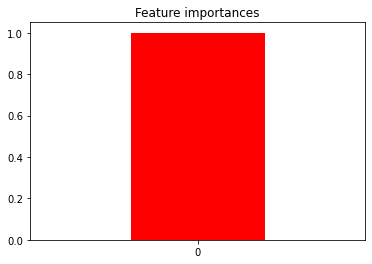

0.7469879518072289

In [18]:
acc = machineLearning.applyModelToDataframe(loanDF, ['duration' ], yCol, RandomForestClassifier, False, 'randomForest')
acc['classificationAcc']

Feature ranking:
1. feature 5 (0.223565)
2. feature 7 (0.199423)
3. feature 6 (0.188989)
4. feature 3 (0.168446)
5. feature 4 (0.148036)
6. feature 0 (0.032448)
7. feature 2 (0.025481)
8. feature 1 (0.013611)


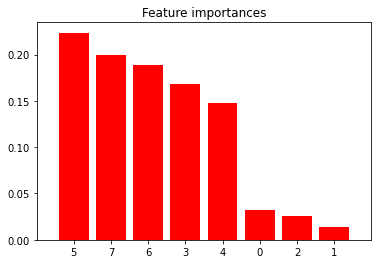

0.7349397590361446

In [19]:
yCol = [ 'status' ]
acc = machineLearning.applyModelToDataframe(loanDF, xCols, yCol, RandomForestClassifier, False, 'randomForest')
acc['classificationAcc']

### Decision Tree Classification: 
Using a decision tree, we can see the particular columns the decision tree splits on with the highest levels of impurity: 

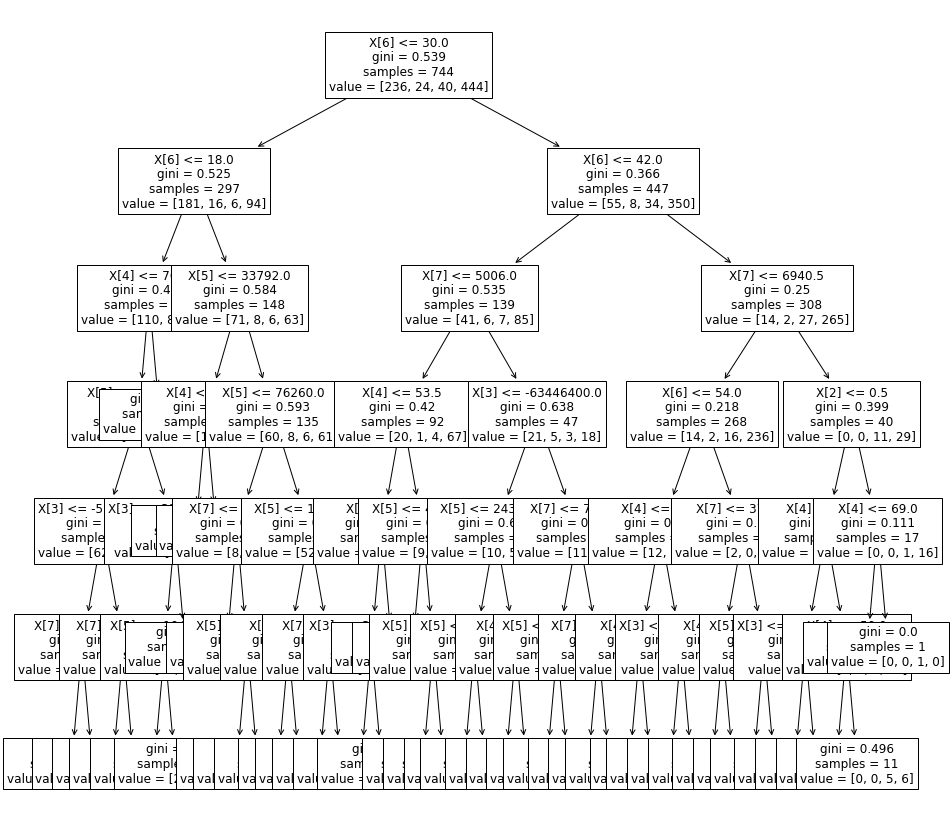

0.6144578313253012

In [20]:
acc = machineLearning.applyModelToDataframe(loanDF, xCols, yCol, lambda: DecisionTreeClassifier(max_depth=6), False, 'decisionTree')
acc['classificationAcc']

### K Nearest Neighbor Classification: 

In [21]:
acc = machineLearning.applyModelToDataframe(loanDF, xCols, yCol, lambda: KNeighborsClassifier(n_neighbors=int(np.sqrt(len(loanDF)))), False)
acc['classificationAcc']

0.5542168674698795

### Correlation Networks: 
We can visualize data from a correlation matrix. All features with a correlation score greater than 0.5 or less than -0.5 by default (showing significant positive correlation in blue and significant negative correlation in red), and with an optional secondary paramater, the correlation threshold can be changed: 

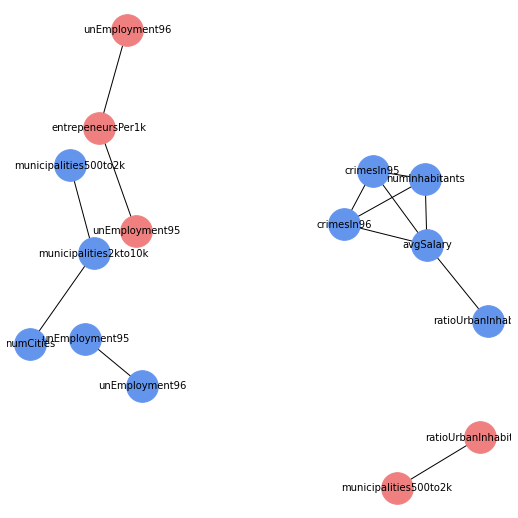

In [22]:
machineLearning.generateCorrelationNetwork(medianChange)

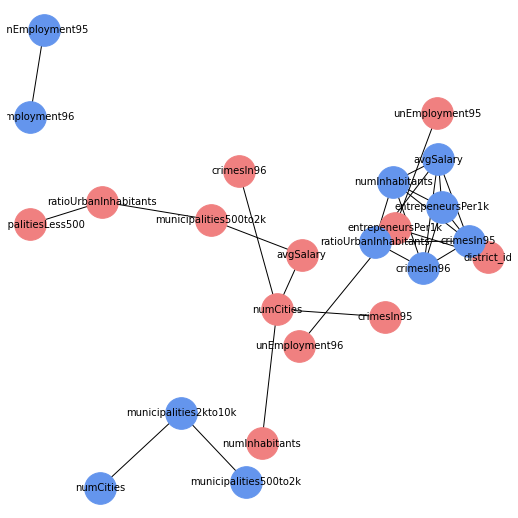

In [23]:
machineLearning.generateCorrelationNetwork(dfAcctsPctChange,0.6)